<a href="https://colab.research.google.com/github/aleks-haksly/Postypashka/blob/main/DA/01%20HW/HW_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [218]:
# Всё необходимое для выполнения данной лабораторной работы!
import requests
from time import sleep

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [219]:
pd.set_option('display.max_columns', 100)

## Задание 1. Парсинг - 10 баллов

В этом задании Вам предстоит работать с API сайта <a target="_blank" href="hh.ru">hh.ru</a>. Документация доступна по <a target="_blank" href="https://github.com/hhru/api/blob/master/docs/vacancies.md#search">ссылке</a>.

**Задача:**
1. выбрать 5 интересующих вас профессий (не смежных, т.е. Аналатик и Data Engineer не считается корректным)
2. затем получить доступные по данным профессиям вакансии в Москве и выделить их физические координаты
3. нанести полученные координаты на карту местоположения компаний

*Пример запроса для профессии:*

In [220]:
URL = 'https://api.hh.ru/vacancies'

params = {
    'text': "Физик-ядерщик",
    'area': 1,
    'page': 0,
    'per_page': 10
}

data = requests.get(URL, params).json()
data

{'items': [],
 'found': 0,
 'pages': 1,
 'page': 0,
 'per_page': 10,
 'clusters': None,
 'arguments': None,
 'fixes': None,
 'suggests': None,
 'alternate_url': 'https://hh.ru/search/vacancy?area=1&enable_snippets=true&items_on_page=10&text=%D0%A4%D0%B8%D0%B7%D0%B8%D0%BA-%D1%8F%D0%B4%D0%B5%D1%80%D1%89%D0%B8%D0%BA'}

Если Ваш запрос прошел успешно, то вы получите следующие ключи (значения данных ключей вы найдете по ссылке на документацию):

In [221]:
data.keys()

dict_keys(['items', 'found', 'pages', 'page', 'per_page', 'clusters', 'arguments', 'fixes', 'suggests', 'alternate_url'])

Выберете для нас 5 наиболее интересных специальностей и получите по ним имеющиеся вакансии:

In [222]:
URL_areas = 'https://api.hh.ru/areas'
URL_professions = 'https://api.hh.ru/professional_roles'
URL_vacancies = 'https://api.hh.ru/vacancies'

In [223]:
data_areas = requests.get(URL_areas).json()
sleep(0.5)
data_professions = requests.get(URL_professions).json()

In [224]:
def get_city_id_by_name(data:dict=data_areas, county_name:str='Россия', city_name:str='Москва') -> str | None:
    """
    Returns the city ID given a country name and city name.

    :param data: A dictionary containing country and city data.
    :param county_name: The name of the country.
    :param city_name: The name of the city.
    :return: The ID of the city if found, otherwise None
    """
    for country in data_areas:
        if country.get('name', []) == county_name:
            for city in country['areas']:
                if city.get('name', []) == city_name:
                    return city.get('id', None)

In [225]:
def get_random_professions_names(data:dict=data_professions, n:int=5) -> list:
    """
    Returns a list of random profession names.

    :param data: A dictionary containing professions data.
    :param n: The number of profession names to return.
    :return: A list of random profession names
    """
    result = []
    profession_categories = [profession_categories.get('name') for profession_categories in data.get('categories')][:-1] #Категорию "другое" не рассматриваем
    # Выберем по 1 случайной профессии из n случайных категорий
    for profession_category in np.random.choice(profession_categories, size=n, replace=False):
        for profession in data_professions.get('categories'):
            if profession.get('name', []) == profession_category:
                result.append(np.random.choice(profession.get('roles'), size=1, replace=False)[0].get('name'))
                break
    return result


In [226]:
def get_vacancies_page(vacancy_name:str, page:int=0, city_id:str='1') -> dict:
    """
    Fetches a page of vacancies based on the vacancy name and city.

    :param vacancy_name: The name of the vacancy to search for.
    :param page: The page number to fetch (defaults to 0).
    :param city: The city to filter vacancies by (defaults to 'Москва').
    :return: A JSON object containing the vacancies or None if an error occurs.
    """
    params = {
        'text': vacancy_name,
        'area': city_id,
        'page': page,
        'per_page': 100,
        'search_field': "name" # чтобы отсеить поиск в описании вакансии, иначе в выдаче много мусора
    }
    try:
        response = requests.get(URL_vacancies, params)
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching vacancies: {e}")
        return None
    return response.json()

In [227]:
def get_vacancies(vacancy_name, city='Москва'):
    """
    Retrieves all vacancies matching the specified vacancy name and city by paginating through the API results.

    :param vacancy_name: The name of the vacancy to search for.
    :param city: The city to filter the vacancies by (defaults to 'Москва').
    :return: A dictionary containing a list of vacancies and the total number found.
    """
    city_id = get_city_id_by_name(city_name=city)
    page = 0
    vacancies = []
    current_page = get_vacancies_page(vacancy_name=vacancy_name, page=page, city_id=city_id)
    if not current_page:
        return{'items': [], 'found': 0, 'fetched': 0}

    vacancies.extend(current_page.get('items', []))
    total_pages = current_page.get('pages', 0)
    total_vacancies = current_page.get('found', 0)

    for page in range(1, total_pages):

        sleep(np.random.rand() + 0.5)

        current_page = get_vacancies_page(vacancy_name=vacancy_name, page=page, city_id=city_id)
        if not current_page:
            break
        vacancies.extend(current_page.get('items', []))

    return {'items': vacancies, 'found': total_vacancies, 'fetched': len(vacancies)}

In [228]:
np.random.seed(42)
vacancies_info = dict()
data = []
for vacancy_name in get_random_professions_names(n=5):
    vacancies = get_vacancies(vacancy_name=vacancy_name)
    data.extend(vacancies.get('items'))
    vacancies_info[vacancy_name] = {
        'found': vacancies.get('found'),
        'fetched': vacancies.get('fetched')
    }
    print(f'{vacancies.get("fetched")} of {vacancies.get("found")} vacancies for {vacancy_name} fetched')

1 of 1 vacancies for Артист, актер, аниматор fetched
43 of 43 vacancies for Агроном fetched
92 of 92 vacancies for Автомойщик fetched
252 of 252 vacancies for Финансовый директор (CFO) fetched
184 of 184 vacancies for Психолог fetched


Посчитайте сколько всего найдено вакансий:

In [229]:
vacancies_info

{'Артист, актер, аниматор': {'found': 1, 'fetched': 1},
 'Агроном': {'found': 43, 'fetched': 43},
 'Автомойщик': {'found': 92, 'fetched': 92},
 'Финансовый директор (CFO)': {'found': 252, 'fetched': 252},
 'Психолог': {'found': 184, 'fetched': 184}}

In [230]:
print(f" Всего вакансий найдено: {sum(v['found'] for v in vacancies_info.values())}")

 Всего вакансий найдено: 572


Создайте структуру данных, которая будет хранить в себе имя компании и ее координаты (широта и долгота):

In [231]:
from collections import namedtuple

Company = namedtuple('Company', ['name', 'lat', 'lng'])

Создайте экземпляр этой структуры данных для каждой компании, которая выставила вакансию:

In [232]:
companies = set(Company(company.get('employer').get('name'), \
                       (company.get('address') or dict()).get('lat'), \
                       (company.get('address') or dict()).get('lng')) \
                for company in data
                )

Найдите количество вакансий, у которых заданы координаты (значения данных может быть пустым):

In [233]:
n_vacances = sum(bool((vacancy.get('address') or dict()).get('lat') and \
                      (vacancy.get('address') or dict()).get('lng')
                     )
                for vacancy in data
                )

In [234]:
print(f'Всего вакансий с координатами: {n_vacances}')

Всего вакансий с координатами: 337


Отберите вакансии, которые расположены в пределах МКАД (можно грубо):

In [235]:
# with gratitude to: https://misha.agency/javascript/rasschet-rasstoyaniya-ot-mkad.html#mkad-coordinates
mkadPoints =  [
	[ 55.774558, 37.842762 ],
	[ 55.76522, 37.842789 ],
	[ 55.755723, 37.842627 ],
	[ 55.747399, 37.841828 ],
	[ 55.739103, 37.841217 ],
	[ 55.730482, 37.840175 ],
	[ 55.721939, 37.83916 ],
	[ 55.712203, 37.837121 ],
	[ 55.703048, 37.83262 ],
	[ 55.694287, 37.829512 ],
	[ 55.68529, 37.831353 ],
	[ 55.675945, 37.834605 ],
	[ 55.667752, 37.837597 ],
	[ 55.658667, 37.839348 ],
	[ 55.650053, 37.833842 ],
	[ 55.643713, 37.824787 ],
	[ 55.637347, 37.814564 ],
	[ 55.62913, 37.802473 ],
	[ 55.623758, 37.794235 ],
	[ 55.617713, 37.781928 ],
	[ 55.611755, 37.771139 ],
	[ 55.604956, 37.758725 ],
	[ 55.599677, 37.747945 ],
	[ 55.594143, 37.734785 ],
	[ 55.589234, 37.723062 ],
	[ 55.583983, 37.709425 ],
	[ 55.578834, 37.696256 ],
	[ 55.574019, 37.683167 ],
	[ 55.571999, 37.668911 ],
	[ 55.573093, 37.647765 ],
	[ 55.573928, 37.633419 ],
	[ 55.574732, 37.616719 ],
	[ 55.575816, 37.60107 ],
	[ 55.5778, 37.586536 ],
	[ 55.581271, 37.571938 ],
	[ 55.585143, 37.555732 ],
	[ 55.587509, 37.545132 ],
	[ 55.5922, 37.526366 ],
	[ 55.594728, 37.516108 ],
	[ 55.60249, 37.502274 ],
	[ 55.609685, 37.49391 ],
	[ 55.617424, 37.484846 ],
	[ 55.625801, 37.474668 ],
	[ 55.630207, 37.469925 ],
	[ 55.641041, 37.456864 ],
	[ 55.648794, 37.448195 ],
	[ 55.654675, 37.441125 ],
	[ 55.660424, 37.434424 ],
	[ 55.670701, 37.42598 ],
	[ 55.67994, 37.418712 ],
	[ 55.686873, 37.414868 ],
	[ 55.695697, 37.407528 ],
	[ 55.702805, 37.397952 ],
	[ 55.709657, 37.388969 ],
	[ 55.718273, 37.383283 ],
	[ 55.728581, 37.378369 ],
	[ 55.735201, 37.374991 ],
	[ 55.744789, 37.370248 ],
	[ 55.75435, 37.369188 ],
	[ 55.762936, 37.369053 ],
	[ 55.771444, 37.369619 ],
	[ 55.779722, 37.369853 ],
	[ 55.789542, 37.372943 ],
	[ 55.79723, 37.379824 ],
	[ 55.805796, 37.386876 ],
	[ 55.814629, 37.390397 ],
	[ 55.823606, 37.393236 ],
	[ 55.83251, 37.395275 ],
	[ 55.840376, 37.394709 ],
	[ 55.850141, 37.393056 ],
	[ 55.858801, 37.397314 ],
	[ 55.867051, 37.405588 ],
	[ 55.872703, 37.416601 ],
	[ 55.877041, 37.429429 ],
	[ 55.881091, 37.443596 ],
	[ 55.882828, 37.459065 ],
	[ 55.884625, 37.473096 ],
	[ 55.888897, 37.48861 ],
	[ 55.894232, 37.5016 ],
	[ 55.899578, 37.513206 ],
	[ 55.90526, 37.527597 ],
	[ 55.907687, 37.543443 ],
	[ 55.909388, 37.559577 ],
	[ 55.910907, 37.575531 ],
	[ 55.909257, 37.590344 ],
	[ 55.905472, 37.604637 ],
	[ 55.901637, 37.619603 ],
	[ 55.898533, 37.635961 ],
	[ 55.896973, 37.647648 ],
	[ 55.895449, 37.667878 ],
	[ 55.894868, 37.681721 ],
	[ 55.893884, 37.698807 ],
	[ 55.889094, 37.712363 ],
	[ 55.883555, 37.723636 ],
	[ 55.877501, 37.735791 ],
	[ 55.874698, 37.741261 ],
	[ 55.862464, 37.764519 ],
	[ 55.861979, 37.765992 ],
	[ 55.850257, 37.788216 ],
	[ 55.850383, 37.788522 ],
	[ 55.844167, 37.800586 ],
	[ 55.832707, 37.822819 ],
	[ 55.828789, 37.829754 ],
	[ 55.821072, 37.837148 ],
	[ 55.811599, 37.838926 ],
	[ 55.802781, 37.840004 ],
	[ 55.793991, 37.840965 ],
	[ 55.785017, 37.841576 ],
	[ 55.780825, 37.842095 ]
]

In [236]:
def in_poly(point, poly = mkadPoints):
    """
    Определяет, находится ли геоточка внутри полигона геоточек или за его пределами.

    :param point: Заданная геоточка в формате [широта, долгота]
    :param poly: Массив геоточек полигона (например, МКАДа)
    :return: True/False (находится внутри/находится за пределами)
    """
    x, y = point
    inside = False
    if not all([x, y]):
        return inside
    j = len(poly) - 1
    for i in range(len(poly)):
        xi, yi = poly[i]
        xj, yj = poly[j]

        intersect = ((yi > y) != (yj > y)) and (x < (xj - xi) * (y - yi) / (yj - yi) + xi)
        if intersect:
            inside = not inside

        j = i

    return inside

In [237]:
vacancies_inside_mkad = list(filter(lambda vacancy: in_poly([(vacancy.get('address') or dict()).get('lat'), (vacancy.get('address') or dict()).get('lng')]), data))
len(vacancies_inside_mkad)

239

Постройте график в координатах "широта-долгота" для отображения вакансий внутри МКАД (не забывайте прописать прозрачность, чтобы увидеть скопления):

In [238]:
lat = [vacany.get('address').get('lat') for  vacany in vacancies_inside_mkad]
lng = [vacany.get('address').get('lng') for  vacany in vacancies_inside_mkad]

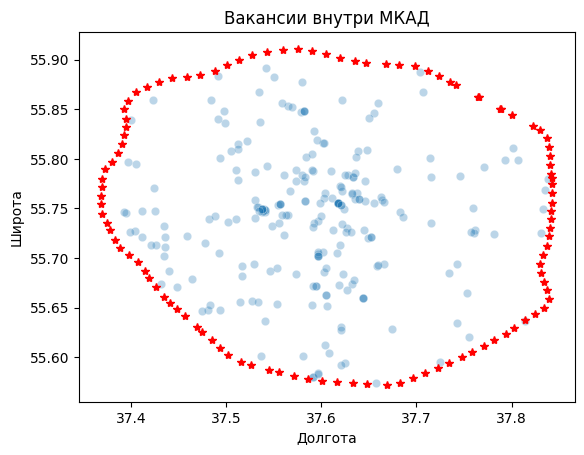

In [239]:
sns.scatterplot(data=pd.DataFrame(vacancies_inside_mkad), x=lng, y=lat, alpha=0.3).set_title('Вакансии внутри МКАД')
for y, x in mkadPoints:
  plt.plot(x, y, 'r*')
plt.xlabel('Долгота')
plt.ylabel('Широта');

**Сделайте выводы о проделанной работе:**

Вакансии найдены и отфильтрованы по признаку нахождения внутри МКАД, в дальнейшем интересно было бы добавить возможность фильтрации по зарпатаной вилке, требуемому опыту работы и свежести вакансии.

Вам предстоит проанализировать датасет, содержащий информацию об бриллианта, их стоимости и остальных характеристиках.



Поясним значения хранящиеся в колонках:
*   `cut` - огранка бриллианта (относится к одной из примерно 10 наиболее распространенных)
*   `color` - цвет бриллианта, прозрачные бриллианты имеют градацию `D-Z`, "более высокие" буквы - более желтоватые, но часто имеют лучшие значения, поскольку цвет трудно определить один раз в кольце
*   `clarity` - чистота бриллианта, наличие включений (внутренних дефектов), чем меньше и мельче, тем лучше
*   `carat_weight` - масса бриллианта (слабо связана с размером бриллианта, т.к. огранка и качество огранки, как правило, играют большую роль)
*   `cut_quality` - качество ограники по системе оценки GIA Cut
*   `lab` - лаборатория оценивания
*   `meas_length` - длина бриллианта
*   `meas_width` - ширина бриллианта
*   `meas_depth` - глубина бриллианта
*   `total_sales_price` - цена бриллианта в долларах.
*    **и прочие колонки**

Скачаем данные:

In [240]:
!gdown 10OJ30qlkE-7zK4JuVTDMY3U4nRB4tu_8
# если работайте в jupyter то скачайте датасет с https://drive.google.com/uc?id=10OJ30qlkE-7zK4JuVTDMY3U4nRB4tu_8

Downloading...
From: https://drive.google.com/uc?id=10OJ30qlkE-7zK4JuVTDMY3U4nRB4tu_8
To: /content/diamonds.csv
100% 35.4M/35.4M [00:00<00:00, 162MB/s]


Создадим DataFrame:

In [241]:
import pandas as pd

diamonds = pd.read_csv("diamonds.csv")

Выведете первые 5 строк датасета:

Найдите количество бриллиантов всего в данном датасете:

Выведите максимальную и минимальную цену бриллианта в формате `номер - цена`:

Посчитайте количество пропусков (пропуском считается значение `unknown` или `None`):

Найдите в каких столбцах присутствуют пропуски:

В нашем датасете присутствуют колонки, которые начинаются с `fancy_color_` или `fluor_`. Большинство значений в этих колонках - `unknown` или `None`, поэтому мы считаем их малоинформативными.

Ваша задача:

найти количество таких колонок, которые начинаются с `fancy_color_` или `fluor_`:

найти количество информативных (не `None` или `unknown`) значений в этих колонках:

удалить данные колонки из датасета, сохранив изменения (в дальнейшем работаем измененным датасетом):

Проделайте тоже самое для колонок, начинающихся с `culet_`:

Посчитайте сколько бы стоил (в тысячах долларов) сейф, в котором хранились бы все бриллианты из датасета:

Немного необоснованных манипуляций.

Выберите из датасета строки с четными индексами и выведете значения (не меняя нумерацию индексов):

А теперь с индексами, кратными 6:

Выберете из датасета только категорильные признаки и выведете датасет:

### Построение графиков

**Требования к графику:**

1.   График должен быть подписан
2.   Оси должны быть подписаны
3.   Должна быть легенда графика
4.   График должен быть информативным (желательно без сильных выбросов)

**Все надписи на русском языке!**

>**Примечание**
>
>График необходимо строить для очищенных данных - в них не должно быть пропусков по осям, по которым строите график. При этом **не перезатирайте** имеющийся датафрейм!

Постройте график `цвет бриллианта - стоимость`:

Постройте график `лабараторная оценка - кол-во бриллиантов`:

Постройте график `вес бриллианта - стоимость`:

Постройте график `система оценки GIA Cut - кол-во бриллиантов`:

Сделайте выводы по построенным графикам